In [1]:
from transformers import TFBertForSequenceClassification, BertTokenizerFast
import numpy as np
import tensorflow as tf

In [2]:
from datasets import concatenate_datasets, load_dataset

In [3]:
fake = load_dataset('csv', data_files='fake.csv', nrows = 10, usecols = ['title', 'text'], split= 'train')
true = load_dataset('csv', data_files='true.csv', nrows = 10, usecols = ['title', 'text'], split = 'train')

In [4]:
fake

Dataset({
    features: ['title', 'text'],
    num_rows: 10
})

In [5]:
fake[0]

{'title': ' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing',
 'text': 'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year

In [6]:
fake.features

{'title': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None)}

In [7]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

C:\Users\Anil\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
def tokenization(data):
    return tokenizer(data['title'], data['text'], padding = True, truncation = True, return_tensors = 'tf') #assuming both columns can be tokenized.

In [10]:
true_ds = true.map(tokenization, batched = True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [11]:
fake_ds = fake.map(tokenization, batched = True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [12]:
true_ds

Dataset({
    features: ['title', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10
})

In [13]:
fake_ds = fake_ds.add_column(name = 'target' , column = np.full(shape = fake.num_rows, fill_value = 0))

In [14]:
true_ds = true_ds.add_column(name = 'target' , column = np.full(shape = true.num_rows, fill_value = 1))

In [15]:
ds = concatenate_datasets([fake_ds, true_ds])

In [16]:
ds

Dataset({
    features: ['title', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'target'],
    num_rows: 20
})

In [17]:
ds = ds.train_test_split(test_size = 0.3, shuffle = True, seed = 42)

In [18]:
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'target'],
        num_rows: 14
    })
    test: Dataset({
        features: ['title', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'target'],
        num_rows: 6
    })
})

In [19]:
ds['train']

Dataset({
    features: ['title', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'target'],
    num_rows: 14
})

In [20]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = "tf")

train_set = ds['train'].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["target"],
    batch_size=4,
    collate_fn=data_collator,
    shuffle=True
)

test_set = ds['test'].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["target"],
    batch_size=4,
    collate_fn=data_collator,
    shuffle=True
)

C:\Users\Anil\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\datasets\arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [21]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [22]:
bert_history = model.fit(train_set, epochs = 5, validation_data = test_set)

Epoch 1/5
4/4 [==============================] - 35s 6s/step - loss: 3.7183 - binary_accuracy: 0.4286 - val_loss: 5.4732 - val_binary_accuracy: 0.3333
Epoch 2/5
4/4 [==============================] - 21s 5s/step - loss: 3.5914 - binary_accuracy: 0.6429 - val_loss: 5.4480 - val_binary_accuracy: 0.4167
Epoch 3/5
4/4 [==============================] - 22s 6s/step - loss: 3.5352 - binary_accuracy: 0.7143 - val_loss: 5.2166 - val_binary_accuracy: 0.6667
Epoch 4/5
4/4 [==============================] - 22s 5s/step - loss: 3.3672 - binary_accuracy: 0.7500 - val_loss: 1.9590 - val_binary_accuracy: 0.6667
Epoch 5/5
4/4 [==============================] - 21s 5s/step - loss: 1.3110 - binary_accuracy: 0.7857 - val_loss: 0.0870 - val_binary_accuracy: 1.0000


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


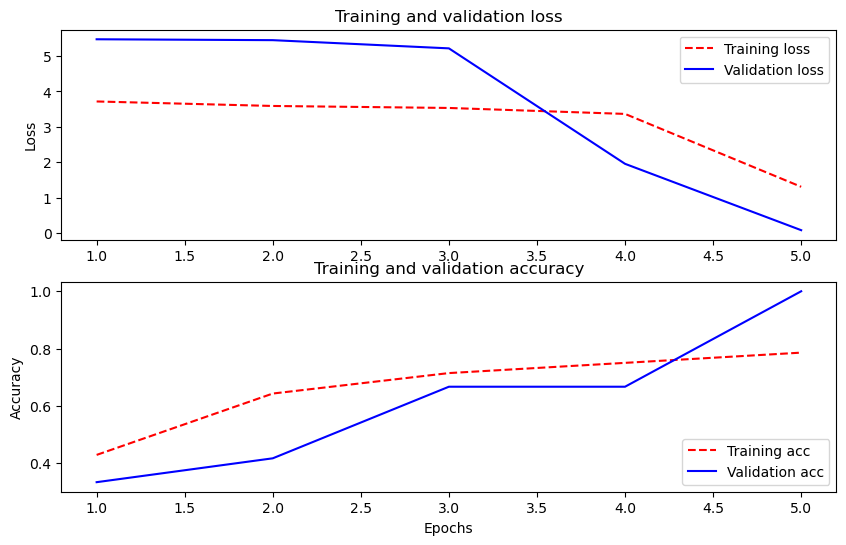

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = bert_history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', linestyle="dashed",label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', linestyle="dashed",label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [25]:
model.evaluate(test_set)

2/2 [==============================] - 2s 787ms/step - loss: 0.0870 - binary_accuracy: 1.0000


[0.0869753286242485, 1.0]

# Fine-tuning using TFTrainer and TFTrainingArguments can be tried in addition to using models like XLNet and T5 and using data augmentation methods, adaptive tuning, PETF methods etc.